# Calculating Smoke Estimates


We try to find out how the impact of the wildfire smokes on Arlington, Texas each year for the most recent 60 years of wildfire data.

Task at hand - "You are to create an annual estimate of wildfire smoke in your assigned city. This estimate is just a number that you can eventually use to build a predictive model. Technically, smoke impact should probably be considered the health, tourism, economic or other social problems that result from the smoke. For this we'll generically call your estimate the wildfire smoke impact. You will consider other potential social and economic impacts during Part 2 of the course project. For now, you need some kind of number to represent an estimate of the smoke your city saw during each annual fire season."


Note - This code example extended by the code snippets developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.3 - August 16, 2024


Here, we load the necessary packages that we'll be using to manipulate, modify and wrangle the data with. We will also import some packages that will help us with computing correlation and fitting data to predict future values. Install necessary libraries as and when required using `%pip install package_name`.

In [ ]:
# %pip install matplotlib

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# To find correlation
from scipy.stats import pearsonr

# For time series estimation
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

Note - this analysis was done in Google Colab, which is a Jupyter Notebook setup that runs in cloud. It gets the data files from your Google Drive, for which it requires the below snipped works by making the data files available in Google Drive. Change to the required path where all the data files are located. This will differ for each user.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/data 512/week 4'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/data 512/week 4


In [3]:
# Function to load the JSON data
def load_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)

fires_info = load_json('fire_distance_info.json')

# Convert the values in fires_info to a pandas dataframe
df_wildfires = pd.DataFrame(list(fires_info.values()))

In [4]:
# Read AQI data
df_aqi_yearly_weighted = pd.read_csv('df_aqi_yearly_weighted.csv')

## Wildfire Data - Exploratory Analysis

We will inspect the rows in the dataframe to get a feeling of which columns might help us develop a good smoke estimate.

In [5]:
print(f"Length of wildfires dataset - {len(df_wildfires)}")
df_wildfires.head(2)

Length of wildfires dataset - 135033


,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,...,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,distance_shortest,avg_distance,perimeter_start
0,1,1,Wildfire,1860,1,1 (1),3940.207089,1594.545237,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (1),...,None,None,0.047590,NaN,No,64888.449849,1.594545e+07,1707.127179,1709.212974,"[47.82096426863667, -123.03391282044802]"
1,2,2,Wildfire,1860,1,1 (1),772.518249,312.627044,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (1),...,None,None,0.071367,NaN,No,23462.288613,3.126270e+06,1705.807580,1706.885089,"[47.760085709530074, -123.05860885146123]"


In [6]:
df_wildfires.columns

Index(['OBJECTID', 'USGS_Assigned_ID', 'Assigned_Fire_Type', 'Fire_Year',
       'Fire_Polygon_Tier', 'Fire_Attribute_Tiers', 'GIS_Acres',
       'GIS_Hectares', 'Source_Datasets', 'Listed_Fire_Types',
       'Listed_Fire_Names', 'Listed_Fire_Codes', 'Listed_Fire_IDs',
       'Listed_Fire_IRWIN_IDs', 'Listed_Fire_Dates', 'Listed_Fire_Causes',
       'Listed_Fire_Cause_Class', 'Listed_Rx_Reported_Acres',
       'Listed_Map_Digitize_Methods', 'Listed_Notes', 'Processing_Notes',
       'Wildfire_Notice', 'Prescribed_Burn_Notice', 'Wildfire_and_Rx_Flag',
       'Overlap_Within_1_or_2_Flag', 'Circleness_Scale', 'Circle_Flag',
       'Exclude_From_Summary_Rasters', 'Shape_Length', 'Shape_Area',
       'distance_shortest', 'avg_distance', 'perimeter_start'],
      dtype='object')

The estimate should only considers fires that are within 650 miles of our assigned city - so filtering out wildfires that are greater than 650 miles.

In [7]:
# Filter out the rows where the distance_shortest is less than or equal to 650
df_wildfires = df_wildfires[df_wildfires['distance_shortest'] <= 650]
print(f"Length of wildfires dataset after distance filter - {len(df_wildfires)}")
df_wildfires.head(2)

Length of wildfires dataset after distance filter - 23669


,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,...,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,distance_shortest,avg_distance,perimeter_start
8,9,9,Wildfire,1880,1,"1 (1), 3 (1)",14946.172721,6048.501507,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (2),...,None,None,0.183134,NaN,No,64423.416282,6.048502e+07,607.892695,612.574951,"[38.83817404563333, -105.08190911997991]"
110,111,111,Wildfire,1908,1,"1 (1), 3 (1)",45.051505,18.231697,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (2),...,None,None,0.995006,1.0,Yes,1517.419772,1.823170e+05,561.147547,561.297275,"[35.51567562298915, -106.31784075215887]"


We see that the OBJECTID and USGS_Assigned_ID are same for all rows that are visible in the above view. We do a check to see if it matches for all rows. If they do, we can safely remove OBJECTID (or USGS_Assigned_ID, either way works.

In [8]:
# Check if OBJECTID and USGS_Assigned_ID are same for all rows
df_wildfires[df_wildfires['OBJECTID'] != df_wildfires['USGS_Assigned_ID']]

,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,...,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,distance_shortest,avg_distance,perimeter_start


In [9]:
# Dropping OBJECTID as they both are duplicates
df_wildfires = df_wildfires.drop(columns=['OBJECTID'])

In [10]:
def get_statistics_for_column(column_name):
    print(f"NA values in '{column_name}' = {df_wildfires[column_name].isna().sum()}")
    return df_wildfires[column_name].describe()

In [11]:
get_statistics_for_column("distance_shortest")

NA values in 'distance_shortest' = 0


,distance_shortest
count,23669.000000
mean,409.040516
std,156.218186
min,20.048358
25%,273.089957
50%,432.697283
75%,562.298728
max,649.986556


In [12]:
get_statistics_for_column("avg_distance")

NA values in 'avg_distance' = 0


,avg_distance
count,23669.000000
mean,409.688683
std,156.083556
min,20.440710
25%,274.103745
50%,433.463289
75%,562.748154
max,657.846393


In [13]:
get_statistics_for_column("GIS_Acres")

NA values in 'GIS_Acres' = 0


,GIS_Acres
count,2.366900e+04
mean,1.837153e+03
std,1.454755e+04
min,1.417178e-06
25%,5.505872e+00
50%,9.847276e+01
75%,1.320860e+03
max,1.566273e+06


While the length and area might seem like good values to add to our smoke estimate, they only describe the shape rather than the actual size. We will stick to using the `GIS_Acres` as that gives us a better estimate.

In [14]:
get_statistics_for_column("Shape_Length")

NA values in 'Shape_Length' = 0


,Shape_Length
count,2.366900e+04
mean,1.356439e+04
std,1.227906e+05
min,1.822902e+00
25%,6.692420e+02
50%,3.507131e+03
75%,1.478428e+04
max,1.757948e+07


In [15]:
get_statistics_for_column("Shape_Area")

NA values in 'Shape_Area' = 0


,Shape_Area
count,2.366900e+04
mean,7.434696e+06
std,5.887184e+07
min,5.735115e-03
25%,2.228147e+04
50%,3.985051e+05
75%,5.345333e+06
max,6.338483e+09


`Assinged_Fire_Type` seeem to be an interesting column as they contain the type of wildfire it is supposed to be. This might play a good role in our smoke estimate, as the level of smoke produced will be highly dependent on the type of fire it is.

In [16]:
# Count of each unique value in "Assigned_Fire_Type"
df_wildfires["Assigned_Fire_Type"].value_counts()

,count
Assigned_Fire_Type,
Wildfire,11948
Prescribed Fire,6859
Likely Wildfire,2974
Unknown - Likely Prescribed Fire,1775
Unknown - Likely Wildfire,113


Based on wikipedia and online research, we get the definition for each of the types above -

1. Wildfire - This refers to an uncontrolled, unplanned fire that spreads through vegetation, often in forests, grasslands, or shrublands. Wildfires are typically started by natural causes (like lightning) or human actions (such as campfires left unattended). They can grow quickly, depending on environmental conditions, and are not intentionally set or managed.

2. Prescribed Fire - This is a fire intentionally set by fire management professionals under controlled conditions to manage ecosystems, reduce excess vegetation, prevent larger wildfires, and maintain biodiversity. Prescribed fires are carefully planned, with specific goals, burn area limits, and safety measures, ensuring they don’t spread uncontrollably.

3. Likely Wildfire - This type refers to fires classified as wildfires based on certain characteristics or evidence, though they may lack a high degree of confirmation. It could be used when there's a strong likelihood of a fire being unplanned or naturally occurring, but the exact origin or cause might not be verified.

4. Unknown - Likely Prescribed Fire - In this category, the fire is thought to be a prescribed fire, but there is not enough evidence to confirm it. This classification may be based on characteristics or situational context that suggest it was set intentionally for land management but lacks full documentation or verification.

5. Unknown - Likely Wildfire - This category represents fires believed to be wildfires but without definitive confirmation. Characteristics like location, time of year, and spread behavior might indicate it’s a natural or unintended fire, but the origin details are uncertain.

Based on this information, we can encode the above nominal field to numeric values - wildfires would produce more smoke as they are uncontrolled, and prescribed fires would most likely have the least smoke produced as they are more controlled. Other options have been ranked relatively.

In [17]:
# We can encode this nominal data into a custom defined scale of 0 to 1
INTENSITY_MAPPING = {
    "Wildfire": 1,
    "Likely Wildfire": 0.75,
    "Unknown - Likely Wildfire": 0.6,
    "Unknown - Likely Prescribed Fire": 0.4,
    "Prescribed Fire": 0.25,
}
# Create new column Intensity based on values in column Assigned_Fire_Type and the above mapping
df_wildfires['Intensity'] = df_wildfires['Assigned_Fire_Type'].map(INTENSITY_MAPPING)
df_wildfires[["Assigned_Fire_Type", "Intensity"]]

,Assigned_Fire_Type,Intensity
8,Wildfire,1.00
110,Wildfire,1.00
114,Wildfire,1.00
115,Wildfire,1.00
117,Wildfire,1.00
...,...,...
134622,Prescribed Fire,0.25
134763,Prescribed Fire,0.25
134770,Prescribed Fire,0.25
134888,Prescribed Fire,0.25


In [18]:
# Check if all fires have "Fire_Year"
print(f"NA values in 'Fire_Year' = {df_wildfires['Fire_Year'].isna().sum()}")

NA values in 'Fire_Year' = 0


We now inspect the properties involving the Circle features.

In [19]:
print(f"NA values in 'Circle_Flag' = {df_wildfires['Circle_Flag'].isna().sum()}")

NA values in 'Circle_Flag' = 19839


From the Wildland_Fire_Polygon_Metadata.xml, we find out the below information about Circle features. Here is a gist of the information -  

Some of the fires appear as near perfect circles. This could be from lightning strikes being counted as small fires or other small fires having a point buffered to the acreage of the fire size because no true polygon was created. A circle circle-ness index was calculated by using the following equation in Field Calculator "4*pi*(Shape_Area/(Shape_Length * Shape_Length))" ... It is simply a way of highlighting some very circular polygons that may be incorrect. We included this measure of circle-ness as an additional field as well so that users could adjust the circle flag setting if needed. Our advisory group decided that any circular fires greater than 1 acre in size should be excluded from the summary raster dataset. Circular fire polygons are highly unlikely to represent the actual area burned. Where fire size was less than 1 acre, the advisory team determined that the risk of misassigning the burned area to the raster was minimal given the fire size. For any circular polygons greater than 1 acre, the risk of misassigning a burned area was too high and hence these were not included in the raster analysis. We included an Exclude_From_Summary_Rasters field to flag circular polygons greater than 1 acre in size so we could exclude them from the raster summaries.

From the above description, it is safe to exclude all features which pertain to the circularity as they are another calculation on top of the Shape_Area, which we are already going to be using. Plus, they also mention that the more circular a fire boundary is, the more likely it is to be not the actual area.


Below, we explore a few more columns to see if there is any useful features available in them.


In [20]:
explore = [
'Listed_Fire_Types',
'Listed_Fire_Names',
'Listed_Fire_Codes',
'Listed_Fire_IDs',
'Listed_Fire_IRWIN_IDs',
'Listed_Fire_Dates',
'Listed_Fire_Causes',
'Listed_Fire_Cause_Class',
'Listed_Rx_Reported_Acres',
'Listed_Map_Digitize_Methods',
]
for col_name in explore:
    # print unique values in columns
    print(f"First 5 unique values in '{col_name}' = {df_wildfires[col_name].unique()[:5]}")
    print()

First 5 unique values in 'Listed_Fire_Types' = ['Wildfire (2)' 'Wildfire (10), Likely Wildfire (1)'
 'Wildfire (6), Likely Wildfire (1)' 'Wildfire (4)'
 'Wildfire (4), Likely Wildfire (2)']

First 5 unique values in 'Listed_Fire_Names' = ['1880 (2)' 'No Fire Name Provided (2)'
 'No Fire Name Provided (8), Nmbap  (2), NMBAP (1)'
 'Nmbap  (2), No Fire Name Provided (4), NMBAP (1)'
 'No Fire Name Provided (4)']

First 5 unique values in 'Listed_Fire_Codes' = ['No code provided (2)' 'No code provided (11)' 'No code provided (7)'
 'No code provided (4)' 'No code provided (6)']

First 5 unique values in 'Listed_Fire_IDs' = ['' '1909.009 (2)' '1909.008 (2), 1909-NMBAP-8 (2)' '1909.004 (2)'
 '1909.007 (2), 1909-NMBAP-7 (2)']

First 5 unique values in 'Listed_Fire_IRWIN_IDs' = ['' 'ED9C8CCE-9F39-4DA4-A3CF-219791B445B0 (1)'
 'DDC0D86D-B510-4470-8067-C7DB7AB15025 (1), 3258FCDC-B0A6-4387-953C-A8992ED4D6DE (1)'
 '93991500-10E5-430F-A506-B1C923039B8A (18)'
 'C05242CC-CE14-419C-A881-939AC7F4B0AF (12)

None of the above fields we explore seem to be useful, so we ignore all of the above nominal fields.

## Calculating the smoke estimate

Based on the above analysis, we identify three major columns that might give us a good smoke estimate -
1. `Intensity` - which is based off on the nominal column `Assigned_Fire_Type` and have been encoded to serve our purpose
2. `GIS_Acres` - area of the fire burned. More the area, more smoke is going to be produced.
3. `avg_distance` - this was a calculated in which we found out the average distance between Arlington (our city) and the wildfire. The further the wildfire is, the less it would affect the smoke within the city. Which means it is inversely proportional.

Based on the above, we arrive at the formula of -

Smoke estimate = (Intensity of fire x Area of wildfire) / Average distance from the city



In [21]:
# Calculating smoke estimate column by multiplying Intensity and GIS_Acres and divide by avg_distance
df_wildfires['smoke_estimate'] = ((df_wildfires['Intensity'] ** 2) * df_wildfires['GIS_Acres']) / (df_wildfires['avg_distance'])

In [22]:
# Filter out the rows where the distance_shortest is less than or equal to 650
df_wildfires = df_wildfires[df_wildfires['distance_shortest'] <= 650]
print(f"Length of wildfires dataset after distance filter - {len(df_wildfires)}")
df_wildfires.head(2)

Length of wildfires dataset after distance filter - 23669


,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,Listed_Fire_Names,...,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,distance_shortest,avg_distance,perimeter_start,Intensity,smoke_estimate
8,9,Wildfire,1880,1,"1 (1), 3 (1)",14946.172721,6048.501507,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (2),1880 (2),...,0.183134,NaN,No,64423.416282,6.048502e+07,607.892695,612.574951,"[38.83817404563333, -105.08190911997991]",1.0,24.398929
110,111,Wildfire,1908,1,"1 (1), 3 (1)",45.051505,18.231697,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (2),No Fire Name Provided (2),...,0.995006,1.0,Yes,1517.419772,1.823170e+05,561.147547,561.297275,"[35.51567562298915, -106.31784075215887]",1.0,0.080263


In [36]:
# We aggregate the smoke estimates for each year
wildfires_final = (
    df_wildfires
      .groupby('Fire_Year')[['smoke_estimate', 'GIS_Acres', 'avg_distance', 'Shape_Area',
                            #  'Circleness_Scale'
                             ]]
      .mean()
      .sort_index()
      .rename(columns={"smoke_estimate": "Smoke_Estimate"})
      .reset_index()
)
wildfires_final

,Fire_Year,Smoke_Estimate,GIS_Acres,avg_distance,Shape_Area
0,1880,24.398929,14946.172721,612.574951,6.048502e+07
1,1908,0.019726,10.999412,546.756649,4.451304e+04
2,1909,0.228752,130.513357,581.682886,5.281688e+05
3,1910,0.024734,13.525721,570.732580,5.473665e+04
4,1911,0.346806,187.803061,534.852897,7.600120e+05
...,...,...,...,...,...
109,2016,3.652977,2963.372248,382.359014,1.199234e+07
110,2017,5.739291,3635.133009,378.080507,1.471086e+07
111,2018,4.389228,2381.317596,382.753685,9.636850e+06
112,2019,0.657889,966.077751,413.550615,3.909578e+06


The estimate should only consider the last 60 years of wildland fire data. We only have data till 2020, so we will select the range of 1960 to 2020.

In [37]:
# include only years from 1960
wildfires_final_from_1960 = wildfires_final[wildfires_final["Fire_Year"] >= 1960].reset_index(drop=True)
wildfires_final_from_1960

,Fire_Year,Smoke_Estimate,GIS_Acres,avg_distance,Shape_Area
0,1960,2.244825,1311.191094,582.316833,5.306202e+06
1,1961,1.769117,1028.188322,581.160027,4.160931e+06
2,1962,1.482874,858.942186,584.695965,3.476016e+06
3,1963,0.290618,169.502290,586.877092,6.859514e+05
4,1964,0.773732,450.288525,579.514276,1.822253e+06
...,...,...,...,...,...
56,2016,3.652977,2963.372248,382.359014,1.199234e+07
57,2017,5.739291,3635.133009,378.080507,1.471086e+07
58,2018,4.389228,2381.317596,382.753685,9.636850e+06
59,2019,0.657889,966.077751,413.550615,3.909578e+06


We visualize and see our smoke estimates to see how they vary over the years.

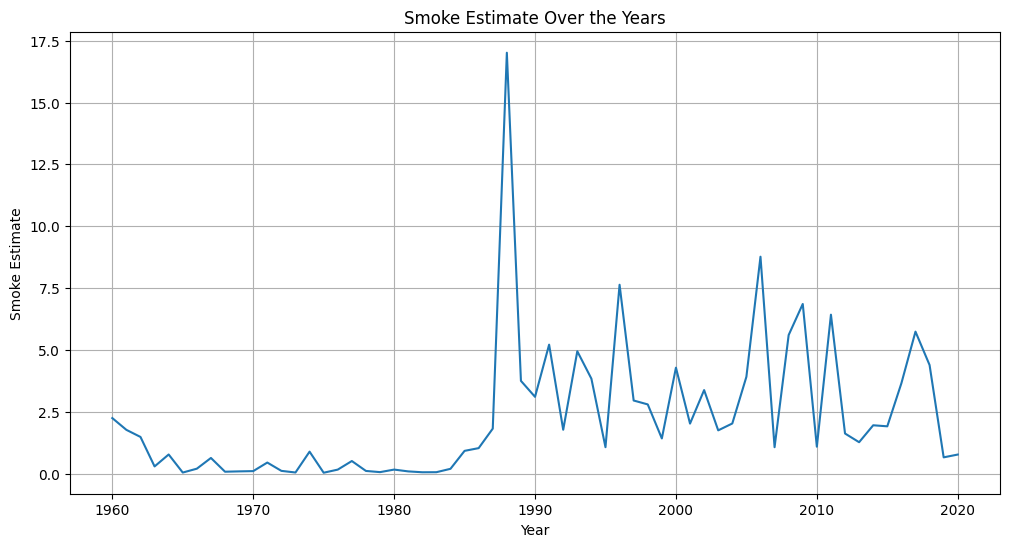

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(wildfires_final_from_1960["Fire_Year"], wildfires_final_from_1960["Smoke_Estimate"])
plt.xlabel("Year")
plt.ylabel("Smoke Estimate")
plt.title("Smoke Estimate Over the Years")
plt.grid(True)
plt.show()

We find out the correlation between our smoke estimates and the AQI values to see how the variation in our estimates affects the AQI values. We restrict the year till 2020 as we only have wildfire data till 2020. To find correlation, the number of rows need to match between the two, so we are restricting the years temporarily to find the correlation.

In [39]:
# Restricting AQI data till 2020
df_aqi_yearly_weighted_till_2020 = df_aqi_yearly_weighted[df_aqi_yearly_weighted["date_local"] <= 2020]
df_aqi_yearly_weighted_till_2020
# print(len(df_aqi_yearly_weighted_till_2020))

# We have AQI data only from 1976, so using only those years
wildfires_final_from_1976 = wildfires_final_from_1960[wildfires_final_from_1960["Fire_Year"] >= 1976]
# print(len(wildfires_final_from_1976))

# # Finding the correlation between wildfires_final and df_aqi_yearly_weighted using scipy.stats pearsonr function
correlation, p_value = pearsonr(
    df_aqi_yearly_weighted_till_2020["0"],
    wildfires_final_from_1976["Smoke_Estimate"]
)

# # Display the correlation
print(f"Pearson correlation coefficient: {correlation}")

Pearson correlation coefficient: -0.31144117897276025


We can see a negative correlation between the two, meaning as one increases, the other one decreases. This means that there is an inverse relationship between these two, so we make use of that into our smoke estimate by performing a `1 / smoke_estimate calculation`, adjusted with a constant value. We can also verify this by the chart below.

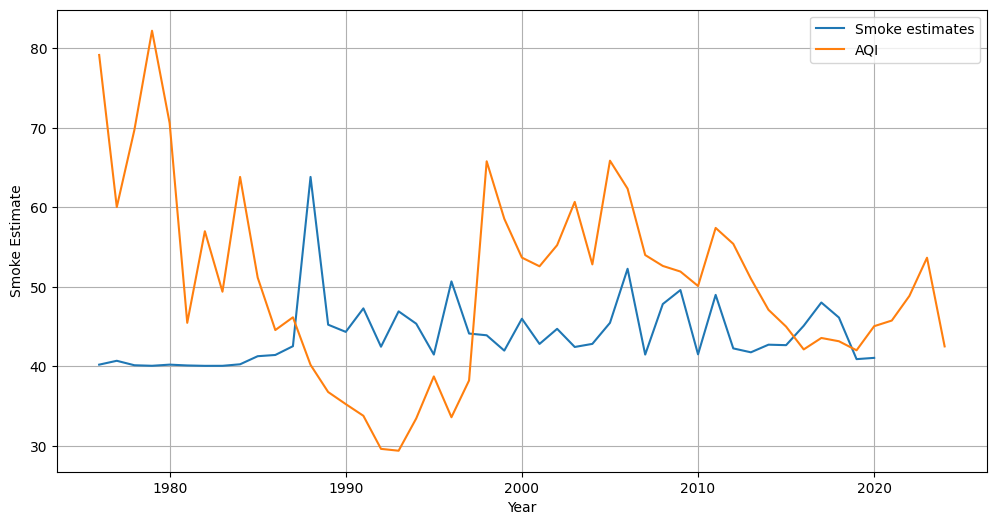

In [40]:
adjusted_wildfires_final = wildfires_final_from_1976.copy()
adjusted_wildfires_final["Smoke_Estimate"] = adjusted_wildfires_final["Smoke_Estimate"] * 1.4 + 40

# plot wildfires_final and df_aqi_yearly_weighted in a line chart
# plt.figure()
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(adjusted_wildfires_final["Fire_Year"], adjusted_wildfires_final["Smoke_Estimate"], label='Smoke estimates')
ax.plot(df_aqi_yearly_weighted["date_local"], df_aqi_yearly_weighted['0'], label='AQI')
ax.set_xlabel('Year')
ax.set_ylabel('Smoke Estimate')
ax.legend()
plt.grid(True)
plt.show()

We see that our smoke estimates and

# Visualizations


### 1. Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city for all fires ranging up to 1800 miles away from your assigned city. Your histogram should indicate the distance cut-off for your modeling work as specified in Step 1.


In [41]:
# We create a new dataframe because we need wildfires up to 1800 miles away
df_wildfires_full = pd.DataFrame(list(fires_info.values()))

<ipython-input-42-63b79d958aeb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wildfires_upto_1800["distance_bin"] = wildfires_upto_1800["avg_distance"] // 50


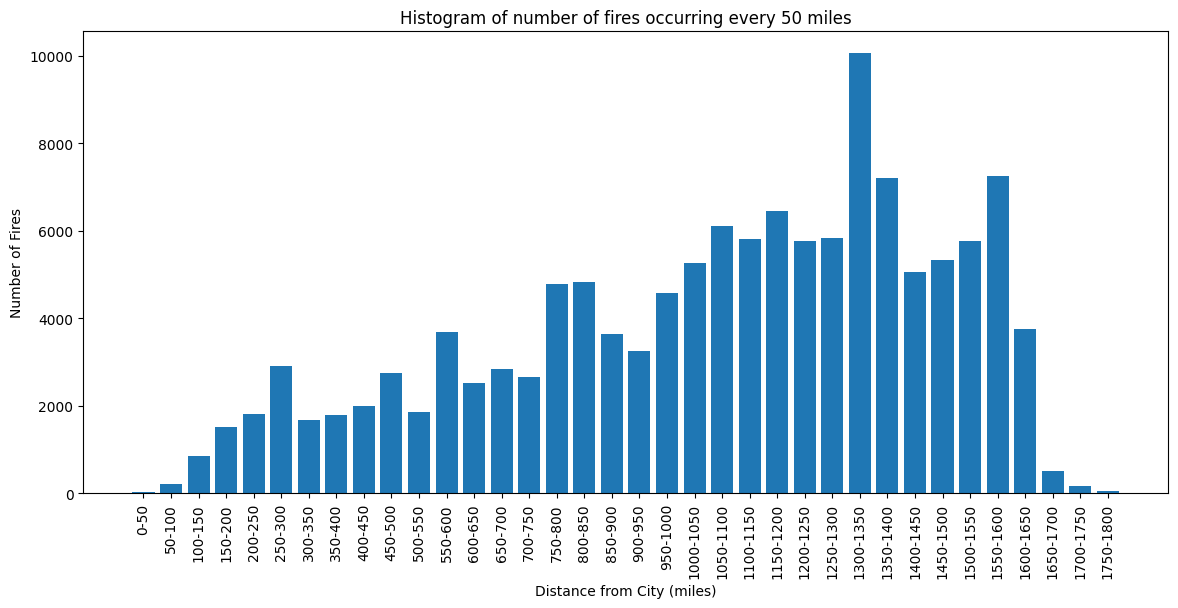

In [42]:
# Using df_wildfires_full, we plot a histogram showing the number of fires occurring every 50 mile distance (using average distance)
wildfires_upto_1800 = df_wildfires_full[df_wildfires_full["avg_distance"] <= 1800]
wildfires_upto_1800["distance_bin"] = wildfires_upto_1800["avg_distance"] // 50
wildfires_upto_1800 = (
    wildfires_upto_1800
      .groupby("distance_bin")
      .size()
      .reset_index(name='count')
)

# Plotting a histogram
plt.figure(figsize=(14, 6))
plt.bar(wildfires_upto_1800["distance_bin"], wildfires_upto_1800["count"])

b = wildfires_upto_1800["distance_bin"]
plt.xticks(wildfires_upto_1800["distance_bin"], [f"{int(b[i]*50)}-{int(b[i]*50)+50}" for i in range(len(b))])
plt.xticks(rotation=90)

plt.xlabel('Distance from City (miles)')
plt.ylabel('Number of Fires')
plt.title('Histogram of number of fires occurring every 50 miles')
plt.show()

### 2. Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.

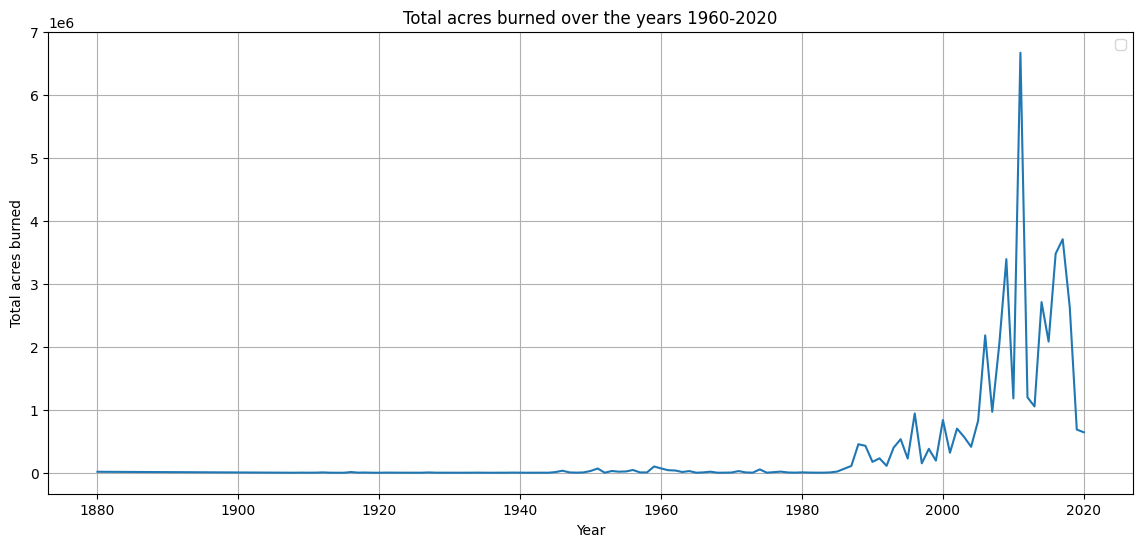

In [43]:
wildfires_acres_burned = (
    df_wildfires
      .groupby("Fire_Year", as_index=False)["GIS_Acres"].sum()
      .sort_values(by="Fire_Year")
)
tot_acres_df = wildfires_acres_burned[wildfires_acres_burned["Fire_Year"] >= 1960]
tot_acres_df

# Plotting the values
plt.figure(figsize=(14, 6))
plt.plot(wildfires_acres_burned["Fire_Year"], wildfires_acres_burned["GIS_Acres"])
plt.title('Total acres burned over the years 1960-2020')
plt.xlabel('Year')
plt.ylabel('Total acres burned')
plt.grid(True)
plt.legend()
plt.show()

### 3. Produce a time series graph containing your fire smoke estimates for your city and the AQI estimates for your city.

We only have AQI data from 1976 for Arlington, so we visualize from 1976 to 2020.

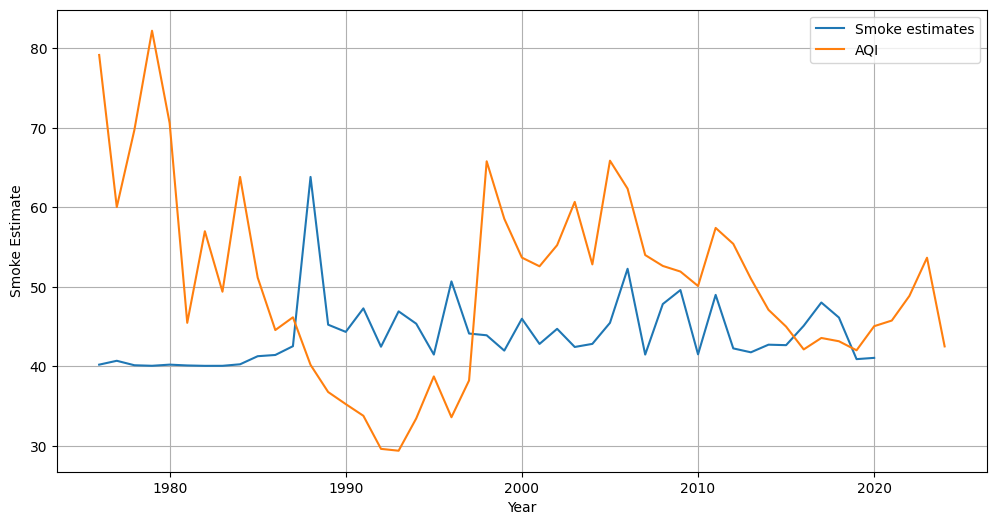

In [44]:
# Plotting the values
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(adjusted_wildfires_final["Fire_Year"], adjusted_wildfires_final["Smoke_Estimate"], label='Smoke estimates')
ax.plot(df_aqi_yearly_weighted["date_local"], df_aqi_yearly_weighted['0'], label='AQI')
ax.set_xlabel('Year')
ax.set_ylabel('Smoke Estimate')
ax.legend()
plt.grid(True)
plt.show()

# Predicting smoke estimates


Here, we develop a predictive model based on the fire data and smoke estimate for Arlington, Texas. The model predicts smoke estimates for every year for the next 25 years (i.e., 2025-2050).

#### Modeling our problem statement


To model this problem as a time series for predicting smoke estimates, we can use an ARIMAX (AutoRegressive Integrated Moving Average with eXogenous variables) model, which combines ARIMA for time series data with the ability to incorporate external or exogenous factors. In this case, our primary series to predict is the annual smoke estimate for a specific city. The exogenous variables will likely include historical wildfire data, categorized by type (e.g., Wildfire, Prescribed Fire, etc.), and other potential factors that impact smoke levels, such as weather conditions or regional fire trends. We’ll preprocess the time series to ensure stationarity, then leverage ARIMAX to capture both the temporal dependencies in smoke estimates and the influence of wildfire and related data.

To fit the model accurately, historical smoke estimates will be divided into training and testing subsets, typically based on the latest available data. During model training, exogenous variables will be carefully chosen and tested for significant correlations with smoke estimates. ARIMAX allows for seasonal adjustments, which will help address any annual or cyclical patterns in smoke data. The model will then generate smoke estimates for each year from 2025 to 2050, with confidence intervals to convey the forecast uncertainty. These intervals will be especially important given the unpredictable nature of wildfire occurrences and climate conditions, providing stakeholders with a range that emphasizes the model’s reliability and acknowledges potential variations in future conditions. I took the help of fellow batchmates Navya Eedula and Abhinav Duvvuri to perfect this section as it involved a lot of optimization and debugging to produce the optimal prediction results.

We start off by fitting an unoptimized ARIMA model and checking the fit coefficients, covariance and metrics to see how well it will perform. We do this on the entire dataset just to test out the waters.

The ARIMA model acronym stands for “Auto-Regressive Integrated Moving Average”. In more details -
* A is the autoregressive component of the ARIMA model, and is represented by AR(p), with the p parameter determining the number of lagged series that we use.
* MA(q) is the moving average model and q is the number of lagged forecasting error terms in the prediction. In an MA(1) model, our forecast is a constant term plus the previous white noise term times a multiplier, added with the current white noise term.

The ARIMA model is an ARMA model yet with a preprocessing step included in the model that we represent using I(d). I(d) is the difference order, which is the number of transformations needed to make the data stationary. So, an ARIMA model is simply an ARMA model on the differenced time series.

In [46]:
model = ARIMA(wildfires_final_from_1960["Smoke_Estimate"])
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         Smoke_Estimate   No. Observations:                   61
Model:                          ARIMA   Log Likelihood                -150.423
Date:                Thu, 31 Oct 2024   AIC                            304.846
Time:                        03:45:45   BIC                            309.068
Sample:                             0   HQIC                           306.500
                                 - 61                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2799      0.573      3.982      0.000       1.158       3.402
sigma2         8.1175      0.951      8.535      0.000       6.253       9.981
Ljung-Box (L1) (Q):                   3.69   Jarque-

Looking at the above results, ARIMAX would likely perform better than ARIMA for predicting smoke estimates in this context because it accounts for exogenous variables that can significantly influence the outcome. In our case, this might be the additional wildfire variables that we are trying to incorporate into our prediction model, like `GIS_Acres`, `Shape_Area`, `avg_distance` etc. While ARIMA relies solely on historical values of the time series itself, ARIMAX is capable of incorporating these additional factors that can directly impact smoke levels. As we saw in the previous charts, since the occurrence of wildfires in previous years correlates with increased smoke levels, using ARIMAX would allow the model to consider this relationship, improving our prediction accuracy.

The only difference between ARIMA and ARIMAX is the addition of an exogenous (external) variable. The ARIMA model works on a single time series data (univariate) whereas ARIMAX uses multiple variables to include the external feature. This will cater to our specific usecase as it allows us to include multiple dependent variables into our model.

In [50]:
# Renaming variables for clarity and readability
wildfire_data = wildfires_final_from_1960

# Prepare endogenous (target) and exogenous (features) variables
smoke_estimate = wildfire_data['Smoke_Estimate']
explanatory_variables = wildfire_data[['GIS_Acres', 'Shape_Area', 'avg_distance']]

# Split data into training and testing sets based on year
train_data_mask = wildfire_data['Fire_Year'] < 2015
test_data_mask = wildfire_data['Fire_Year'] >= 2015

train_smoke_estimate = smoke_estimate[train_data_mask]
train_explanatory_variables = explanatory_variables[train_data_mask]
test_smoke_estimate = smoke_estimate[test_data_mask]
test_explanatory_variables = explanatory_variables[test_data_mask]

In [52]:
# Define ARIMAX model orders to test
arimax_orders = [(1,1,1), (2,1,2), (1,1,2)]
model_results = {}

# Fit ARIMAX models for different orders and calculate MSE
for arimax_order in arimax_orders:
   try:
       arimax_model = SARIMAX(train_smoke_estimate, exog=train_explanatory_variables, order=arimax_order).fit()
       predictions = arimax_model.predict(
           start=len(train_smoke_estimate),
           end=len(train_smoke_estimate) + len(test_smoke_estimate) - 1,
           exog=test_explanatory_variables
       )
       mse_value = mean_squared_error(test_smoke_estimate, predictions)
       model_results[arimax_order] = mse_value
   except Exception as e:
       print(f"Model fitting error, with order of {arimax_order}: {e}")

print("MSE for different orders:", model_results)
# Select the best performing model order based on MSE
optimal_order = min(model_results.items(), key=lambda x: x[1])[0]
print(f"Optimal performance order: {optimal_order}")

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py


MSE for different orders: {(1, 1, 1): 2.9541534718494105, (2, 1, 2): 14.522135169256265, (1, 1, 2): 14.522135169256265}

Best performing order: (1, 1, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


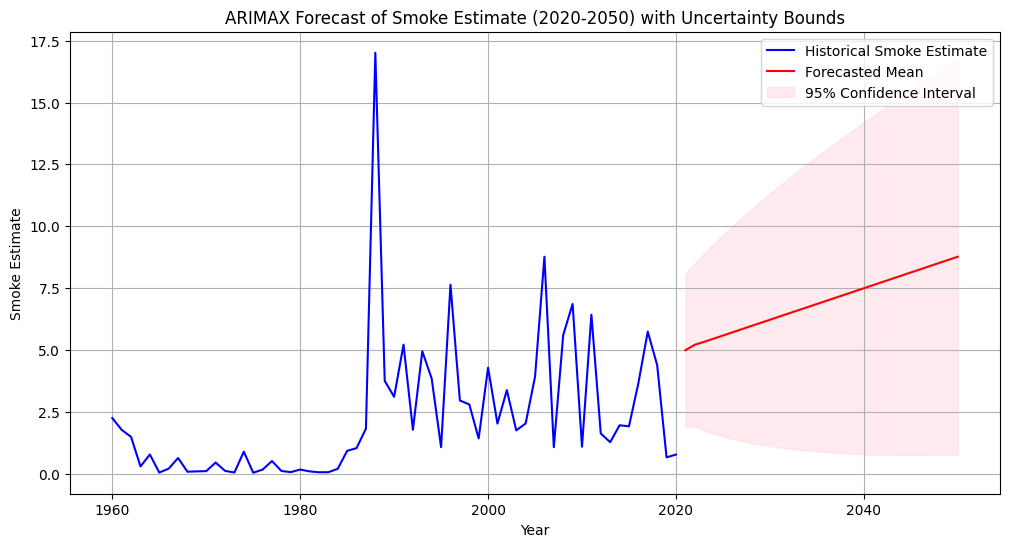


Test Set MSE: 2.9541534718494105

Model Summary:
                               SARIMAX Results                                
Dep. Variable:         Smoke_Estimate   No. Observations:                   55
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -97.224
Date:                Thu, 31 Oct 2024   AIC                            206.449
Time:                        04:05:44   BIC                            218.383
Sample:                             0   HQIC                           211.051
                                 - 55                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
GIS_Acres     2.014e-10        nan        nan        nan         nan         nan
Shape_Area    7.726e-07   4.19e-08     18.449      0.000    6.91e-07    8.5

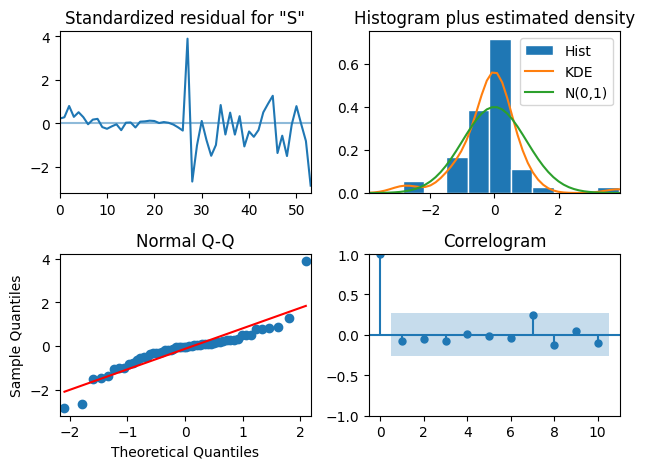

In [53]:
# Final ARIMAX model using the optimal order
final_arimax_model = SARIMAX(
   train_smoke_estimate,
   exog=train_explanatory_variables,
   order=optimal_order
)

try:
   final_arimax_result = final_arimax_model.fit()

   # Make predictions on the test set
   test_predictions = final_arimax_result.predict(
       start=len(train_smoke_estimate),
       end=len(train_smoke_estimate) + len(test_smoke_estimate) - 1,
       exog=test_explanatory_variables
   )

   # Calculate the MSE for the test predictions
   test_mse = mean_squared_error(test_smoke_estimate, test_predictions)

   # Create future exogenous variables (2021-2050) using linear trends
   future_exog_variables = pd.DataFrame(index=range(2021, 2051))
   for col in explanatory_variables.columns:
       trend = np.polyfit(wildfire_data['Fire_Year'], explanatory_variables[col], 1)
       trend_line = np.poly1d(trend)
       future_exog_variables[col] = trend_line(future_exog_variables.index)

   # Forecast smoke estimate for 2020-2050 using the ARIMAX model
   forecast_model = SARIMAX(
       smoke_estimate,
       exog=explanatory_variables,
       order=optimal_order
   ).fit()

   # Generate forecast and confidence intervals
   forecast_result = forecast_model.get_forecast(
       steps=len(future_exog_variables),
       exog=future_exog_variables
   )
   forecast_mean_values = forecast_result.predicted_mean
   forecast_confidence_interval = forecast_result.conf_int(alpha=0.05)

   # Plot historical data and forecast with confidence intervals
   plt.figure(figsize=(12, 6))

   # Plot historical data
   plt.plot(wildfire_data['Fire_Year'], smoke_estimate, label='Historical Smoke Estimate', color='blue')

   # Plot forecasted mean
   plt.plot(future_exog_variables.index, forecast_mean_values, label='Forecasted Mean', color='red')

   # Plot confidence intervals
   plt.fill_between(
       future_exog_variables.index,
       forecast_confidence_interval.iloc[:, 0],
       forecast_confidence_interval.iloc[:, 1],
       color='pink',
       alpha=0.3,
       label='95% Confidence Interval'
   )

   plt.title("ARIMAX Forecast of Smoke Estimate (2020-2050) with Uncertainty Bounds")
   plt.xlabel("Year")
   plt.ylabel("Smoke Estimate")
   plt.legend()
   plt.grid(True)
   plt.show()

   # Print model summary and test MSE
   print(f"\nTest Set MSE: {test_mse}")
   print("\nModel Summary:")
   print(final_arimax_result.summary())

   # Display diagnostic plots for the ARIMAX model
   final_arimax_result.plot_diagnostics()
   plt.tight_layout()
   plt.show()

except Exception as e:
   print(f"Error in model fitting or forecasting: {e}")

From the above plot, we can see that -
* Past Data (Blue Line): This shows how smoke levels have changed over the years, with ups and downs. We can see a general increase since 1980, but with a lot of variation.
* Forecast (Red Line): This predicts future smoke levels. As we can see, our model is predicting a steady increase in the smoke levels in the future (2020 to 2050). The model expects the smoke levels to steadily increase, as shown by the flat line.
* Confidence Interval (Pink Shaded Area): This region is the range where the actual smoke levels are likely to be. The wider it gets, the less certain the model is about its prediction. This uncertainity is expected in forecasting statistical models.


Understanding the various plots -

The results we obtain are satisfactory and generally consistent. The two main things we need to verify our results are the standardized residuals plot (in the top left) and the Q-Q plot (in the bottom left). The residual plots indicate that there are many records that are clustered near the 0 mark which have very less to no deviations from normality. This indicates that the fit of our model is good. The Q-Q plot also shows that the residuals follow a linear partter for the most parts, suggesting that the residuals are approximately normally distributed (desired property of Q-Q plots in time-series prediction).

Inference of the results -
* MSE: This measures how accurate the model's predictions were in the past. A low MSE means the model was pretty good at predicting past values. In our case, it is a super low value (MSE = 2.95), which means our predictions might be very accurate.
* Flat Trend: While the model was accurate in the past, the flat forecast might be a problem. If smoke levels are expected to change due to factors like climate change, a flat line might not be realistic.



Our model predicts takes in how smoke levels have changed over time and predicts what they might look like in the future. While this output seems to be satisfactory, it is not guaranteed to hold in real life where multiple confounding variables are influencing the real-life values, especially if there are big changes like climate change.